In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2, tqdm
%matplotlib inline

In [2]:
from importlib import reload

In [3]:
from utils import saveVideo, show, drawShape

In [4]:
import laneFindingPipeline

In [5]:
undistort = laneFindingPipeline.Undistorter()

In [6]:
from glob import glob
undistort.fit(glob('camera_cal/*.jpg'))

A Jupyter Widget

In [7]:
# Load video
fpath = 'challenge_video.mp4'
import skvideo.io
reader = skvideo.io.FFmpegReader(fpath)
frames = []
for (i, f) in enumerate(tqdm.tqdm_notebook(
    reader.nextFrame(), 
    total=reader.inputframenum,
)):
    frames.append(f)

A Jupyter Widget

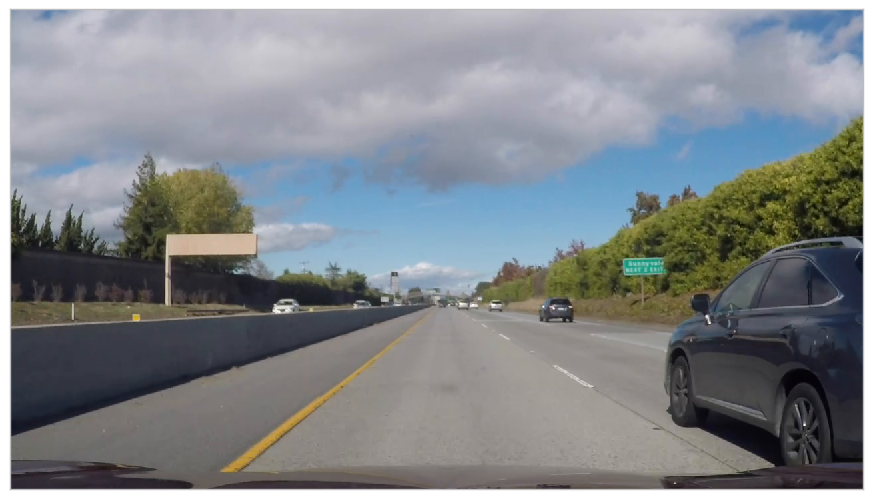

In [8]:
show(frames[-1]);

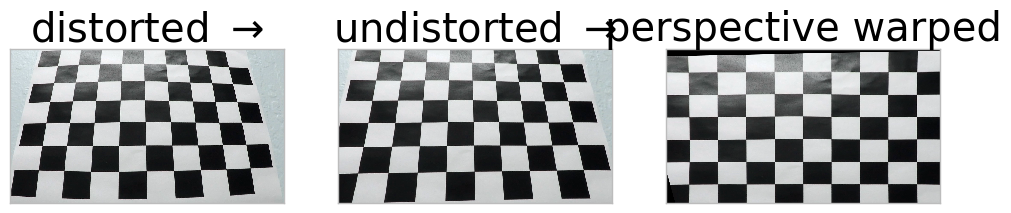

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
dist = cv2.imread('camera_cal/calibration3.jpg')
undist = undistort(dist)
show(dist, axes[0], r'distorted $\rightarrow$')
show(undist, axes[1], r'undistorted $\rightarrow$')
show(laneFindingPipeline.transformChessboard(undist), axes[2], 'perspective warped')
fig.savefig('doc/undistorted.png')

Set parameters for perspective transform.

In [10]:
perspective = laneFindingPipeline.PerspectiveTransformer()

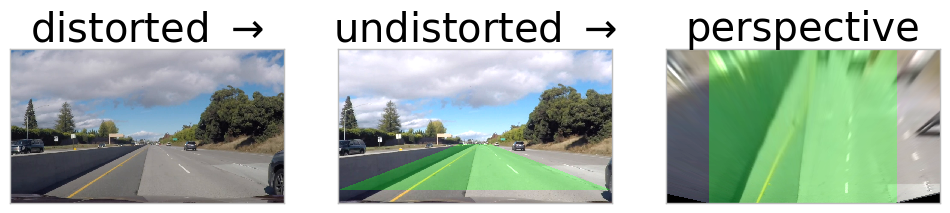

In [11]:
dist = frames[400]
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
undist = undistort(dist)
show(dist, axes[0], r'distorted $\rightarrow$')
show(drawShape(undist, perspective.src), axes[1], r'undistorted $\rightarrow$')

show(drawShape(perspective(undist), perspective.dst), axes[2], 'perspective')
fig.savefig('doc/undistorted-road.png')

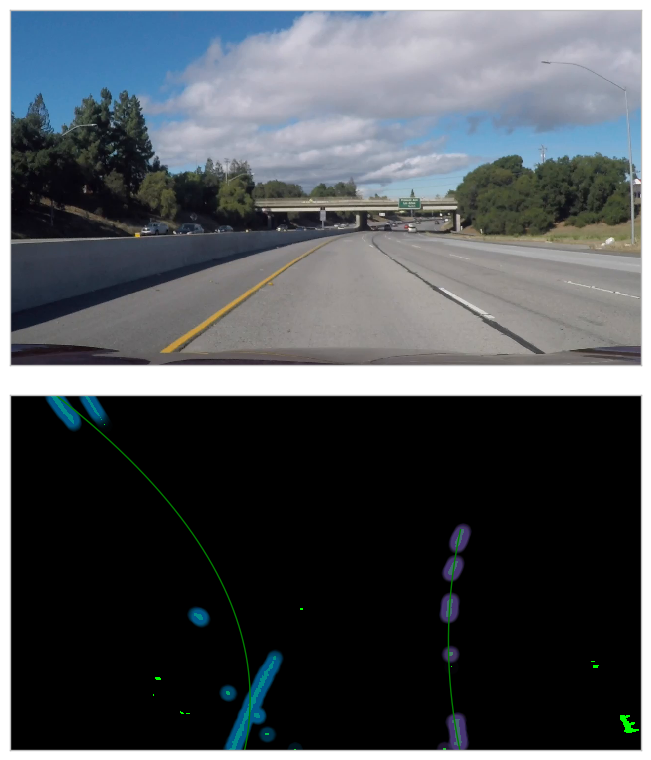

In [12]:
laneFinder = laneFindingPipeline.LaneFinder(undistort=undistort)
laneFinder.show(frames[0]);

In [13]:
inputFrames = frames[:100]

In [14]:
import utils

laneFinder = laneFindingPipeline.LaneFinder(undistort)
fig, axes = plt.subplots(nrows=2)
def inputs():
    for frame in inputFrames:
        laneFinder.show(frame, axes=axes)
        yield utils.fig2img(fig)
        for ax in axes:
            ax.clear()
vid = saveVideo(inputs(), 'laneFits-challenge.mp4', total=len(inputFrames))
fig.clf()
del fig
vid

A Jupyter Widget

Measure FPS without plotting.

In [15]:
%%time
laneFinder = laneFindingPipeline.LaneFinder(undistort)
for frame in tqdm.tqdm_notebook(inputFrames, unit='frame'):
    laneFinder(frame)

A Jupyter Widget


CPU times: user 8 s, sys: 0 ns, total: 8 s
Wall time: 6.45 s


# Show the result unperspective'd.

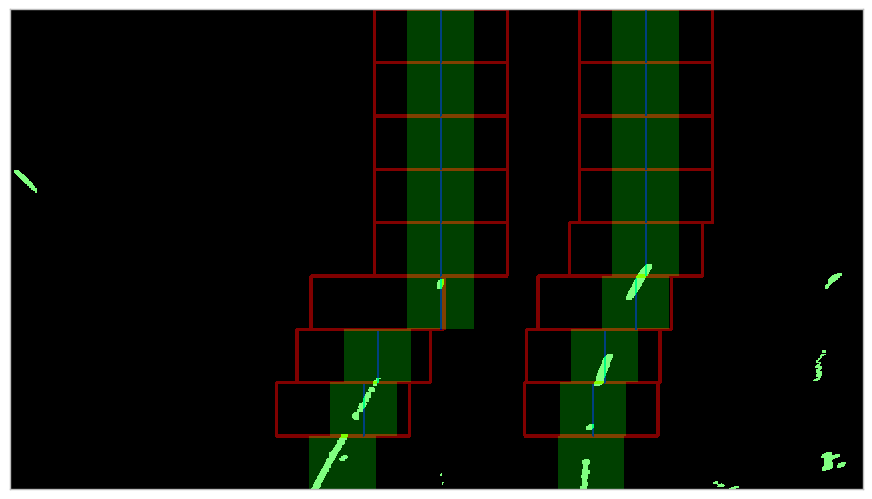

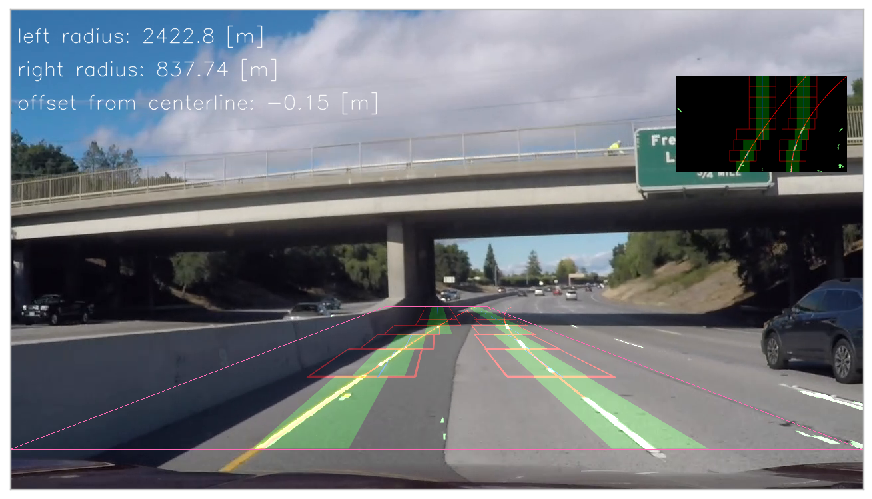

In [44]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder(undistort)
frame = frames[100]

# warped = laneFinder.perspective(laneFinder.undistort(frame))
# hls = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)
# show(hls[:, :, 2])

repro = laneFinder.preprocess(frame, color=True)
painted = laneFinder.initialDiscovery.paintCentroids(laneFinder.preprocess(frame, color=False))
composite = cv2.addWeighted(repro, 1, painted, 0.5, 0)
show(composite);

fig, ax = show(laneFinder.draw(frame, showTrapezoid=True, showLane=False), clearTicks=True);

In [46]:
inputFrames = frames[550:690]
#inputFrames = frames[1000:]
inputFrames = frames
laneFinder = laneFindingPipeline.LaneFinder(undistort)
vid = saveVideo((
    laneFinder.draw(frame)
    for frame in inputFrames
), 'drawn-centroids-challenge.mp4', total=len(inputFrames))
import time
time.sleep(2)
vid

A Jupyter Widget